# インポート

In [1]:
import create_population
import pandas as pd
from pathlib import Path
import create_population
from feature_producing import FeatureCreator
from training import Trainer
from evaluationing import Evaluator
import re
import predictioning
from feature_producing_prediction import PredictionFeatureCreator
%load_ext autoreload


In [43]:
%autoreload

# 学習母集団の作成
期間を指定すると、学習母集団である（日付、race_id、horse_id）の組みを作る

In [66]:
population = create_population.create(
    from_ ="2023-01-01",
    to_ = "2023-12-31",
)

In [ ]:
# 各年の数を確認
population["date"].dt.year.value_counts().sort_index()

date
2018    48604
2019    47574
2020    48282
2021    47821
2022    47220
2023    47672
Name: count, dtype: int64

# データ加工

In [4]:
import preprocessing
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
df["horse_id"].nunique()

22

In [14]:
%autoreload

In [74]:
#レース結果テーブルの前処理
results_preprocessd = preprocessing.process_results()

In [13]:
# 重複チェック
results_preprocessd.duplicated(subset=["race_id", "horse_id"]).sum()

np.int64(0)

In [76]:
# 欠損チェック
results_preprocessd.isnull().sum()

race_id        0
horse_id       0
jockey_id      0
trainer_id     0
owner_id       0
rank           0
umaban         0
wakuban        0
tansyo_odds    0
popularity     0
kinryou        0
sex            0
age            0
weight         0
weight_diff    0
dtype: int64

In [8]:
# 馬の過去成績テーブルの前処理
horse_results_preprocessd = preprocessing.process_horse_results()

In [9]:
horse_results_preprocessd

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_condition,race_class,n_horses
0,2021101429,2024-11-09,9.0,0.0,0.2,0.0,1,1400,0.0,4.0,14.0
1,2021101429,2024-10-06,1.0,1140.0,0.0,1.0,1,1400,0.0,3.0,13.0
2,2021101429,2024-09-01,2.0,625.2,0.4,0.0,1,1400,0.0,5.0,7.0
3,2021101429,2024-08-10,2.0,629.2,0.0,0.0,1,1400,0.0,5.0,14.0
4,2021101429,2024-04-06,13.0,0.0,0.9,1.0,1,1600,1.0,7.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
711582,2019100398,2022-01-27,2.0,52.0,0.4,1.0,0,1400,0.0,NaN,6.0
711583,2019100398,2022-01-04,2.0,48.0,0.0,0.0,0,1400,0.0,NaN,9.0
711584,2019100398,2021-12-16,1.0,70.0,0.0,0.0,0,1400,0.0,1.0,9.0
711585,2019100398,2021-10-26,2.0,14.0,0.1,1.0,0,1000,1.0,1.0,12.0


In [10]:
# 形式、欠損値を確認
horse_results_preprocessd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700274 entries, 0 to 711586
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   horse_id          700274 non-null  int64         
 1   date              700274 non-null  datetime64[ns]
 2   rank              700274 non-null  float64       
 3   prize             700274 non-null  float64       
 4   rank_diff         699553 non-null  float64       
 5   weather           699658 non-null  float64       
 6   race_type         700274 non-null  int64         
 7   course_len        700274 non-null  int64         
 8   ground_condition  700269 non-null  float64       
 9   race_class        337222 non-null  float64       
 10  n_horses          700266 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 64.1 MB


In [83]:
# 欠損チェック
horse_results_preprocessd.isnull().sum()

horse_id                0
date                    0
rank                    0
prize                   0
rank_diff             260
weather               219
race_type               0
course_len              0
ground_condition        4
race_class          60543
n_horses                0
dtype: int64

In [16]:
%autoreload

In [17]:
# レース情報テーブルの加工
race_info_preprocess  = preprocessing.process_race_info()

In [12]:
race_info_preprocess

,race_id,date,race_type,around,course_len,weather,ground_state,race_class,place
0,201801010101,2018-07-28,1,0.0,1800,0,0.0,1.0,1
1,201801010102,2018-07-28,0,0.0,1000,0,0.0,1.0,1
2,201801010103,2018-07-28,0,0.0,2400,0,0.0,1.0,1
3,201801010104,2018-07-28,0,0.0,1700,0,0.0,1.0,1
4,201801010105,2018-07-28,1,0.0,1500,0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...
20725,202310030808,2023-09-03,0,0.0,1000,0,0.0,2.0,10
20726,202310030809,2023-09-03,1,0.0,1200,0,0.0,3.0,10
20727,202310030810,2023-09-03,0,0.0,1700,0,0.0,4.0,10
20728,202310030811,2023-09-03,1,0.0,1200,0,0.0,6.0,10


In [18]:
# 欠損チェック
race_info_preprocess.isnull().sum()

race_id                0
date                   0
race_type              0
around               897
course_len           161
weather                0
ground_condition    4787
race_class          1886
place                  0
dtype: int64

In [74]:
# 血統テーブルの加工
import preprocessing

In [75]:
peds = preprocessing.process_peds()

In [78]:
peds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35426 entries, 0 to 35425
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   (horse_id,)  35426 non-null  int64 
 1   (sire_id,)   35426 non-null  object
 2   (bms_id,)    35426 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [79]:
sire_leaidng = preprocessing.process_sire_leading()

In [88]:
sire_leaidng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2862 entries, 0 to 2861
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   page_id     2862 non-null   object 
 1   sire_id     2862 non-null   int64  
 2   year        2862 non-null   int64  
 3   race_type   2862 non-null   int64  
 4   n_races     2862 non-null   float64
 5   n_wins      2862 non-null   float64
 6   course_len  2862 non-null   float64
 7   winrate     2520 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 179.0+ KB


# 特徴量作成

In [ ]:
from feature_producing import FeatureCreator
%load_ext autoreload

In [ ]:
%autoreload

In [88]:
fp = FeatureCreator()
features = fp.create_features()

In [89]:
# 重複チェック
features.duplicated(subset=["race_id", "horse_id"]).sum()

0

# 学習

In [ ]:
from training import Trainer
%load_ext autoreload

In [97]:
%autoreload

In [ ]:
trainer = Trainer()
%load_ext autoreload

In [ ]:
trainer = Trainer(config_filepath="config.yaml")
evaluation_df = trainer.run(
    valid_start_date="2022-10-01",
    test_start_date="2023-01-01",
    importance_filename="importance_new.csv",
    evaluation_filename="evaluation_new.csv"

[100]	training's binary_logloss: 0.153178	valid_1's binary_logloss: 0.206081


# 精度評価

In [1]:
from evaluationing import Evaluator
%load_ext autoreload

In [ ]:
%autoreload

In [2]:
evaluator = Evaluator()

In [ ]:
evaluator = Evaluator(evaluation_filename="evaluation_5year.csv")


# 予測

In [4]:
df = pd.read_csv("../data/03_train/evaluation_course.csv",sep="\t")
df

,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred
0,202301010101,2021101429,1,1,1.2,1,5,0.620179
1,202301010101,2021105872,0,2,4.1,2,8,0.171050
2,202301010101,2021106854,0,3,59.9,6,6,0.013518
3,202301010101,2021105553,0,4,16.6,3,4,0.062265
4,202301010101,2021100648,0,5,23.9,5,1,0.021018
...,...,...,...,...,...,...,...,...
47268,202310030812,2020105644,0,8,62.8,11,1,0.009409
47269,202310030812,2018106584,0,9,125.6,12,7,0.002638
47270,202310030812,2020101781,0,10,9.8,5,2,0.058724
47271,202310030812,2019106647,0,11,37.2,10,4,0.008369


In [6]:
df["expect_return"] = df["tansyo_odds"] * df["pred"]
df

,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred,expect_return
0,202301010101,2021101429,1,1,1.2,1,5,0.620179,0.744215
1,202301010101,2021105872,0,2,4.1,2,8,0.171050,0.701305
2,202301010101,2021106854,0,3,59.9,6,6,0.013518,0.809755
3,202301010101,2021105553,0,4,16.6,3,4,0.062265,1.033594
4,202301010101,2021100648,0,5,23.9,5,1,0.021018,0.502319
...,...,...,...,...,...,...,...,...,...
47268,202310030812,2020105644,0,8,62.8,11,1,0.009409,0.590891
47269,202310030812,2018106584,0,9,125.6,12,7,0.002638,0.331271
47270,202310030812,2020101781,0,10,9.8,5,2,0.058724,0.575491
47271,202310030812,2019106647,0,11,37.2,10,4,0.008369,0.311310


In [9]:
bet_df = df.query("expect_return > 1.0")
bet_df

,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred,expect_return
3,202301010101,2021105553,0,4,16.6,3,4,0.062265,1.033594
11,202301010102,2020104346,0,4,8.6,4,4,0.142034,1.221493
15,202301010102,2020104250,0,8,17.0,6,6,0.062836,1.068217
17,202301010102,2020106395,0,10,22.0,7,11,0.056393,1.240656
23,202301010103,2020105632,0,4,6.2,4,3,0.168365,1.043863
...,...,...,...,...,...,...,...,...,...
47185,202310030806,2020102750,0,14,47.5,13,13,0.024551,1.166194
47196,202310030807,2018110113,0,9,45.8,13,5,0.031480,1.441802
47207,202310030808,2020102702,0,2,2.6,1,4,0.386141,1.003966
47228,202310030809,2020100815,0,10,2.2,1,6,0.514041,1.130890


In [10]:
# 実際にtarget = 1の馬に賭けた場合の収益を計算してみる（１円かけたとき）
bet_df["payoff"] = bet_df["tansyo_odds"] * bet_df["target"]
bet_df

C:\Users\Onoe Daichi\AppData\Local\Temp\ipykernel_15580\2100538659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bet_df["payoff"] = bet_df["tansyo_odds"] * bet_df["target"]


,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred,expect_return,payoff
3,202301010101,2021105553,0,4,16.6,3,4,0.062265,1.033594,0.0
11,202301010102,2020104346,0,4,8.6,4,4,0.142034,1.221493,0.0
15,202301010102,2020104250,0,8,17.0,6,6,0.062836,1.068217,0.0
17,202301010102,2020106395,0,10,22.0,7,11,0.056393,1.240656,0.0
23,202301010103,2020105632,0,4,6.2,4,3,0.168365,1.043863,0.0
...,...,...,...,...,...,...,...,...,...,...
47185,202310030806,2020102750,0,14,47.5,13,13,0.024551,1.166194,0.0
47196,202310030807,2018110113,0,9,45.8,13,5,0.031480,1.441802,0.0
47207,202310030808,2020102702,0,2,2.6,1,4,0.386141,1.003966,0.0
47228,202310030809,2020100815,0,10,2.2,1,6,0.514041,1.130890,0.0


In [12]:
# 回収率
total_payoff = bet_df["payoff"].sum()
total_bet = len(bet_df)
return_rate = total_payoff / total_bet
total_payoff, total_bet, return_rate

(np.float64(1794.5), 1864, np.float64(0.9627145922746781))

In [24]:
import numpy as np

np.linspace(0.8, 2, 100)

array([0.8       , 0.81212121, 0.82424242, 0.83636364, 0.84848485,
       0.86060606, 0.87272727, 0.88484848, 0.8969697 , 0.90909091,
       0.92121212, 0.93333333, 0.94545455, 0.95757576, 0.96969697,
       0.98181818, 0.99393939, 1.00606061, 1.01818182, 1.03030303,
       1.04242424, 1.05454545, 1.06666667, 1.07878788, 1.09090909,
       1.1030303 , 1.11515152, 1.12727273, 1.13939394, 1.15151515,
       1.16363636, 1.17575758, 1.18787879, 1.2       , 1.21212121,
       1.22424242, 1.23636364, 1.24848485, 1.26060606, 1.27272727,
       1.28484848, 1.2969697 , 1.30909091, 1.32121212, 1.33333333,
       1.34545455, 1.35757576, 1.36969697, 1.38181818, 1.39393939,
       1.40606061, 1.41818182, 1.43030303, 1.44242424, 1.45454545,
       1.46666667, 1.47878788, 1.49090909, 1.5030303 , 1.51515152,
       1.52727273, 1.53939394, 1.55151515, 1.56363636, 1.57575758,
       1.58787879, 1.6       , 1.61212121, 1.62424242, 1.63636364,
       1.64848485, 1.66060606, 1.67272727, 1.68484848, 1.69696

In [16]:
df["payoff"] = df["tansyo_odds"] * df["target"]

In [19]:
# defaultdictで新しいからのものを用意してくれる。今回はリスト。普通の辞書型ではappendする際すでにリストに入っている状態を想定しているので使えない
from collections import defaultdict

result = defaultdict(list)
for exp in np.linspace(0.8, 2, 100):
    bet_df = df.query(f"expect_return > {exp}")
    total_payoff = bet_df["payoff"].sum()
    total_bet = len(bet_df)
    return_rate = total_payoff / total_bet
    result["expect_return"].append(exp)
    result["total_bet"].append(total_bet)
    result["total_payoff"].append(total_payoff)
    result["return_rate"].append(return_rate)
    # print(exp, total_payoff, total_bet, return_rate)
result_df = pd.DataFrame(result)
result_df

,expect_return,total_bet,total_payoff,return_rate
0,0.800000,6164,5311.4,0.861681
1,0.812121,5756,4820.0,0.837387
2,0.824242,5383,4426.8,0.822367
3,0.836364,5041,4235.8,0.840270
4,0.848485,4702,3984.6,0.847427
...,...,...,...,...
95,1.951515,31,0.0,0.000000
96,1.963636,31,0.0,0.000000
97,1.975758,31,0.0,0.000000
98,1.987879,30,0.0,0.000000


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

<Axes: xlabel='expect_return', ylabel='return_rate'>

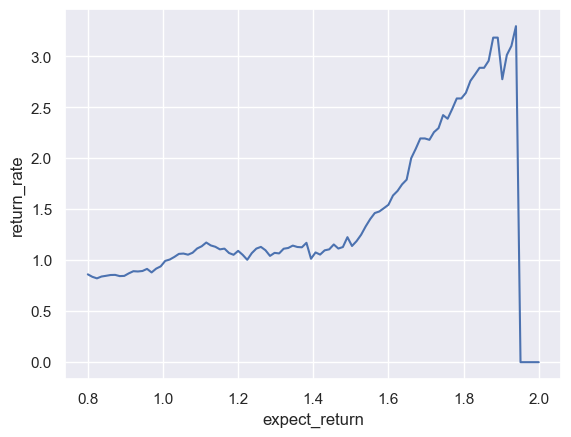

In [21]:
sns.lineplot(result_df, x = "expect_return", y = "return_rate")

In [22]:
result_df.sort_values("return_rate", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate
94,1.939394,32,105.5,3.296875
90,1.890909,39,124.2,3.184615
89,1.878788,39,124.2,3.184615
93,1.927273,34,105.5,3.102941
92,1.915152,35,105.5,3.014286


# キャリブレーション・プロット

## どれくらい予測が信頼できるのか

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("../data/03_train/evaluation_course.csv",sep="\t")
df

,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred
0,202301010101,2021101429,1,1,1.2,1,5,0.620179
1,202301010101,2021105872,0,2,4.1,2,8,0.171050
2,202301010101,2021106854,0,3,59.9,6,6,0.013518
3,202301010101,2021105553,0,4,16.6,3,4,0.062265
4,202301010101,2021100648,0,5,23.9,5,1,0.021018
...,...,...,...,...,...,...,...,...
47268,202310030812,2020105644,0,8,62.8,11,1,0.009409
47269,202310030812,2018106584,0,9,125.6,12,7,0.002638
47270,202310030812,2020101781,0,10,9.8,5,2,0.058724
47271,202310030812,2019106647,0,11,37.2,10,4,0.008369


In [3]:
# predの分布を２０個の範囲に区切る
pd.cut(df["pred"], bins=20).value_counts()

pred
(-0.000841, 0.043]    30145
(0.043, 0.086]         6642
(0.086, 0.129]         3539
(0.129, 0.172]         2171
(0.172, 0.215]         1413
(0.215, 0.258]          977
(0.258, 0.301]          692
(0.301, 0.344]          490
(0.344, 0.387]          360
(0.387, 0.43]           244
(0.43, 0.473]           182
(0.473, 0.516]          119
(0.516, 0.559]           72
(0.559, 0.602]           64
(0.602, 0.645]           57
(0.645, 0.688]           49
(0.731, 0.774]           23
(0.688, 0.731]           22
(0.774, 0.817]           11
(0.817, 0.86]             1
Name: count, dtype: int64

In [4]:
df["pred_bins"] = pd.cut(df["pred"], bins=20)
df.head()

,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred,pred_bins
0,202301010101,2021101429,1,1,1.2,1,5,0.620179,"(0.602, 0.645]"
1,202301010101,2021105872,0,2,4.1,2,8,0.171050,"(0.129, 0.172]"
2,202301010101,2021106854,0,3,59.9,6,6,0.013518,"(-0.000841, 0.043]"
3,202301010101,2021105553,0,4,16.6,3,4,0.062265,"(0.043, 0.086]"
4,202301010101,2021100648,0,5,23.9,5,1,0.021018,"(-0.000841, 0.043]"


In [13]:
# pred_binsが同じもの同士その時のtargetをグループ化。その後、平均を取る
df.groupby("pred_bins")["target"].mean()

C:\Users\Onoe Daichi\AppData\Local\Temp\ipykernel_133668\18705444.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("pred_bins")["target"].mean()


pred_bins
(-0.000841, 0.043]    0.019638
(0.043, 0.086]        0.088226
(0.086, 0.129]        0.125459
(0.129, 0.172]        0.169968
(0.172, 0.215]        0.227176
(0.215, 0.258]        0.243603
(0.258, 0.301]        0.296243
(0.301, 0.344]        0.328571
(0.344, 0.387]        0.388889
(0.387, 0.43]         0.422131
(0.43, 0.473]         0.461538
(0.473, 0.516]        0.445378
(0.516, 0.559]        0.416667
(0.559, 0.602]        0.546875
(0.602, 0.645]        0.526316
(0.645, 0.688]        0.653061
(0.688, 0.731]        0.545455
(0.731, 0.774]        0.739130
(0.774, 0.817]        0.636364
(0.817, 0.86]         0.000000
Name: target, dtype: float64

In [14]:
df.groupby("pred_bins")["pred"].mean()

C:\Users\Onoe Daichi\AppData\Local\Temp\ipykernel_133668\3768389221.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("pred_bins")["pred"].mean()


pred_bins
(-0.000841, 0.043]    0.011332
(0.043, 0.086]        0.062051
(0.086, 0.129]        0.105425
(0.129, 0.172]        0.148707
(0.172, 0.215]        0.191816
(0.215, 0.258]        0.234740
(0.258, 0.301]        0.277812
(0.301, 0.344]        0.321056
(0.344, 0.387]        0.363956
(0.387, 0.43]         0.406385
(0.43, 0.473]         0.447677
(0.473, 0.516]        0.493790
(0.516, 0.559]        0.533610
(0.559, 0.602]        0.579681
(0.602, 0.645]        0.623572
(0.645, 0.688]        0.666869
(0.688, 0.731]        0.707010
(0.731, 0.774]        0.754105
(0.774, 0.817]        0.793174
(0.817, 0.86]         0.859537
Name: pred, dtype: float64

In [11]:
# 各ビンごとの予測勝率の平均値で代表化する
df["pred_mean"] = df.groupby("pred_bins")["pred"].transform("mean")
df

C:\Users\Onoe Daichi\AppData\Local\Temp\ipykernel_133668\3129715750.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["pred_mean"] = df.groupby("pred_bins")["pred"].transform("mean")


,race_id,horse_id,target,rank,tansyo_odds,popularity,umaban,pred,pred_bins,pred_mean
0,202301010101,2021101429,1,1,1.2,1,5,0.620179,"(0.602, 0.645]",0.623572
1,202301010101,2021105872,0,2,4.1,2,8,0.171050,"(0.129, 0.172]",0.148707
2,202301010101,2021106854,0,3,59.9,6,6,0.013518,"(-0.000841, 0.043]",0.011332
3,202301010101,2021105553,0,4,16.6,3,4,0.062265,"(0.043, 0.086]",0.062051
4,202301010101,2021100648,0,5,23.9,5,1,0.021018,"(-0.000841, 0.043]",0.011332
...,...,...,...,...,...,...,...,...,...,...
47268,202310030812,2020105644,0,8,62.8,11,1,0.009409,"(-0.000841, 0.043]",0.011332
47269,202310030812,2018106584,0,9,125.6,12,7,0.002638,"(-0.000841, 0.043]",0.011332
47270,202310030812,2020101781,0,10,9.8,5,2,0.058724,"(0.043, 0.086]",0.062051
47271,202310030812,2019106647,0,11,37.2,10,4,0.008369,"(-0.000841, 0.043]",0.011332


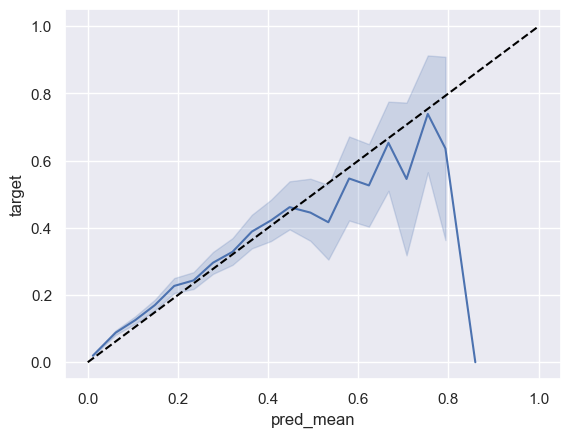

In [15]:
sns.lineplot(data=df, x="pred_mean", y="target")
sns.lineplot(x =[0,1], y=[0,1], color="black", linestyle = "--")
plt.show()

キャリブレーションプロット：
    ・モデルの予測確率が実際の観測確率とどれだけ一致しているかを視覚的に確認するためのグラフ

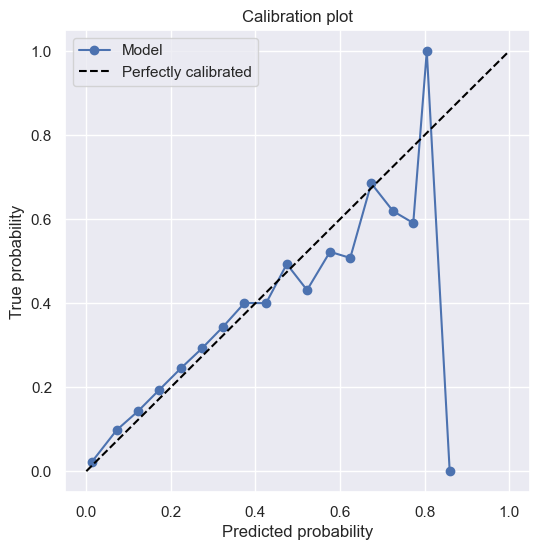

In [43]:
from sklearn.calibration import calibration_curve

# predとtargetを使ってキャリブレーションカーブを計算
prob_true, prob_pred = calibration_curve(df["target"], df["pred"], n_bins=20)

# キャリブレーションプロットを描く
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--',color ="black", label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot')
plt.legend()
plt.show()

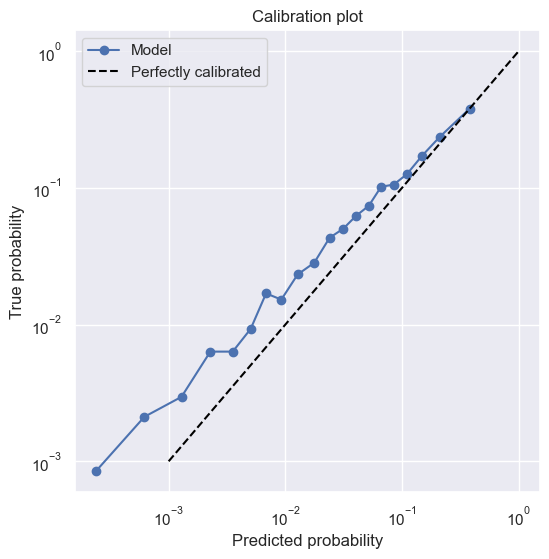

In [17]:
from sklearn.calibration import calibration_curve

# predとtargetを使ってキャリブレーションカーブを計算
prob_true, prob_pred = calibration_curve(
    df["target"], df["pred"], n_bins=20, strategy="quantile")

# キャリブレーションプロットを描く
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0.001, 1], [0.001, 1], linestyle='--',color ="black", label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

In [39]:
prob_pred

array([0.01289769, 0.07193305, 0.1225704 , 0.17281303, 0.2234864 ,
       0.27345308, 0.32356078, 0.3740898 , 0.425228  , 0.47423845,
       0.52210601, 0.57639681, 0.62428984, 0.67404537, 0.72567775,
       0.77337933, 0.8053419 , 0.85953671])

ブライアスコア：
    予測確率が正確なほど小さくなる

In [23]:
from sklearn.metrics import brier_score_loss

brier_score_loss(df["target"], df["pred"])

np.float64(0.05892663927125041)

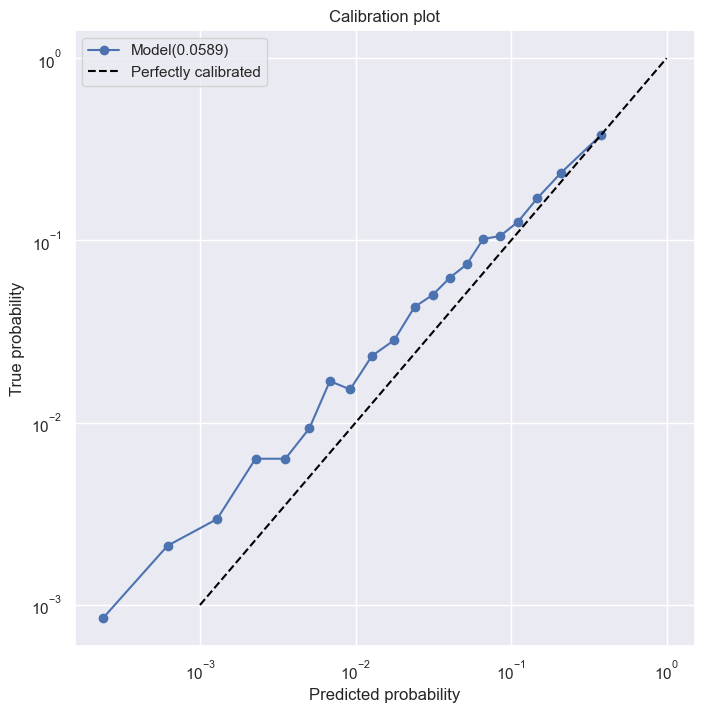

In [60]:
brier_score_loss = brier_score_loss(df["target"], df["pred"])
# predとtargetを使ってキャリブレーションカーブを計算
prob_true, prob_pred = calibration_curve(
    df["target"], df["pred"], n_bins=20, strategy="quantile")

# キャリブレーションプロットを描く
plt.figure(figsize=(8, 8))
plt.plot(
    prob_pred, prob_true, marker='o', label=f'Model({brier_score_loss:.4f})'
)
plt.plot([0.001, 1], [0.001, 1], linestyle='--',color ="black", label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration plot')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## 単勝オッズと勝率の関係

<Axes: xlabel='odds_prob', ylabel='Count'>

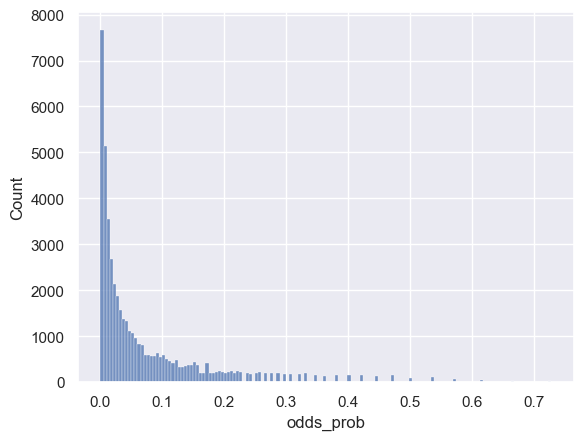

In [28]:
df["odds_prob"] = 0.8 / df["tansyo_odds"]
sns.histplot(data=df, x="odds_prob", )

In [24]:
def plot_calibration(df,pred_col="pred", target_col="target", bins=20, strategy="quantile"):
    brier_score = brier_score_loss(df[target_col], df[pred_col])
    prob_true, prob_pred = calibration_curve(
        df[target_col], df[pred_col], n_bins=bins, strategy="quantile"
    )
    plt.figure(figsize=(5, 5))
    plt.plot(
        prob_pred, prob_true, marker='o', label=f'Model({brier_score:.4f})'
    )
    plt.plot([0.001, 1], [0.001, 1], linestyle='--',color ="black", label='Perfectly calibrated')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title('Calibration plot')
    if strategy == "quantile":
        plt.xscale("log")
        plt.yscale("log")
    plt.legend()
    plt.show()

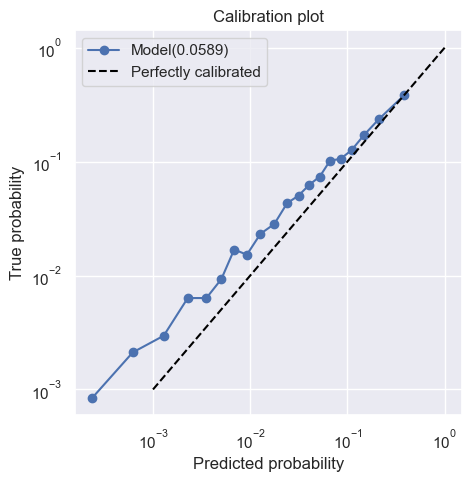

In [25]:
plot_calibration(df)

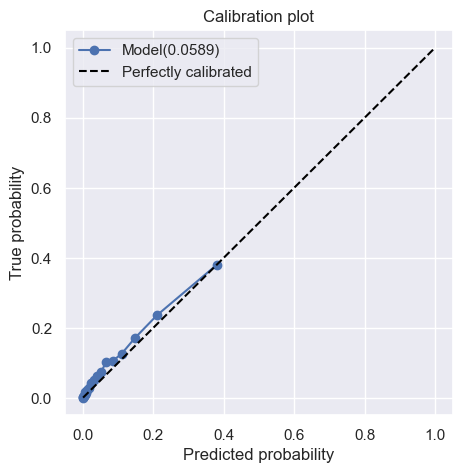

In [26]:
plot_calibration(df, strategy="uniform")

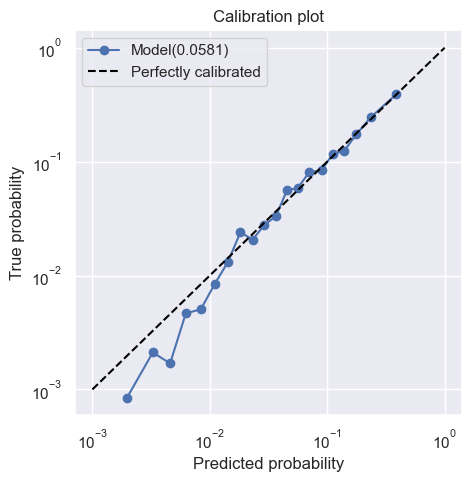

In [29]:
plot_calibration(df, pred_col="odds_prob")

## 低勝率帯を切り捨てる

In [33]:
evaluator = Evaluator()

best result:
{'expect_return': 1.4181818181818182,
 'n_hits': 15.0,
 'return_rate': 1.1815151515151514,
 'sharp_ratio': 0.4375780804677647,
 'std': 0.4148177425183508,
 'total_bet': 330.0,
 'total_payoff': 389.9}


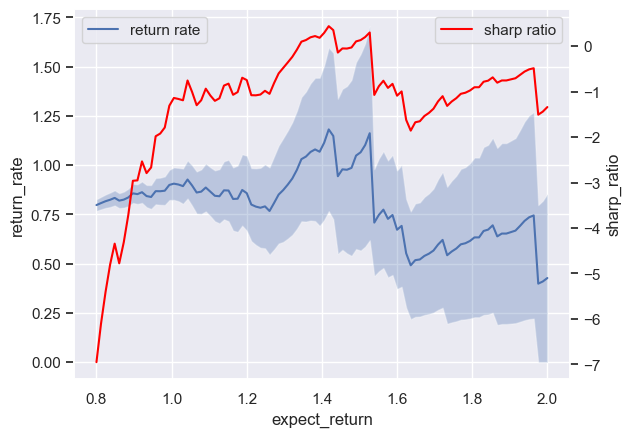

In [34]:
result_df = evaluator.bet_by_expect_return(min_exp=0.8, max_exp=2.0)

In [36]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
51,1.418182,330,389.9,1.181515,0.414818,15,0.437578
52,1.430303,320,367.4,1.148125,0.422453,14,0.350631
60,1.527273,220,255.7,1.162273,0.543332,9,0.298662
50,1.406061,350,389.9,1.114000,0.391364,15,0.291289
48,1.381818,379,409.3,1.079947,0.363394,17,0.220002


In [37]:
evaluator.evaluation_df = evaluator.evaluation_df.query("pred >0.01")

best result:
{'expect_return': 1.4181818181818182,
 'n_hits': 15.0,
 'return_rate': 1.4126811594202897,
 'sharp_ratio': 0.8339312760470317,
 'std': 0.4948623121277628,
 'total_bet': 276.0,
 'total_payoff': 389.9}


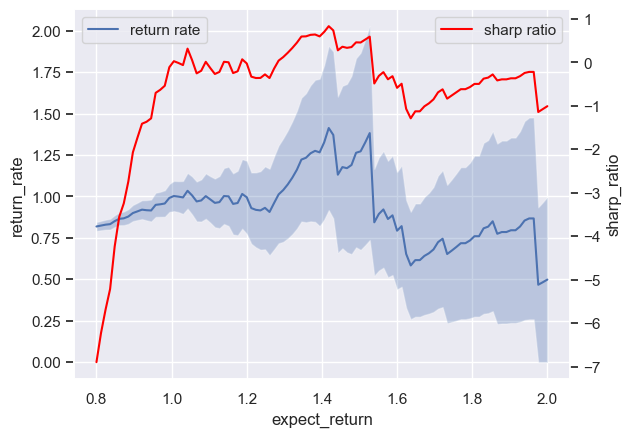

In [38]:
result_df = evaluator.bet_by_expect_return(min_exp=0.8, max_exp=2.0)

In [39]:
result_df.sort_values("sharp_ratio", ascending=False).head()

,expect_return,total_bet,total_payoff,return_rate,std,n_hits,sharp_ratio
51,1.418182,276,389.9,1.412681,0.494862,15,0.833931
52,1.430303,268,367.4,1.370896,0.503386,14,0.736801
50,1.406061,294,389.9,1.326190,0.464942,15,0.701573
48,1.381818,321,409.3,1.275078,0.428199,17,0.642407
47,1.369697,337,424.7,1.260237,0.410227,18,0.634375


# PLAYWRIGHTの使い方
- 関数製作中

In [1]:
!pip install playwright

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 MB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 4.4 MB/s eta 0:00:00


In [2]:
!playwright install

163.5 MiB [                    ] 0% 0.0s163.5 MiB [                    ] 0% 241.0s163.5 MiB [                    ] 0% 158.0s163.5 MiB [                    ] 0% 137.2s163.5 MiB [                    ] 0% 134.6s163.5 MiB [                    ] 0% 119.6s163.5 MiB [                    ] 0% 104.9s163.5 MiB [                    ] 0% 98.7s163.5 MiB [                    ] 0% 88.8s163.5 MiB [                    ] 0% 78.1s163.5 MiB [                    ] 0% 75.1s163.5 MiB [                    ] 0% 67.2s163.5 MiB [                    ] 0% 61.4s163.5 MiB [                    ] 0% 56.1s163.5 MiB [                    ] 0% 60.8s163.5 MiB [                    ] 0% 55.9s163.5 MiB [                    ] 0% 55.8s163.5 MiB [                    ] 0% 53.2s163.5 MiB [                    ] 0% 50.6s163.5 MiB [                    ] 0% 49.7s163.5 MiB [                    ] 0% 56.7s163.5 MiB [                    ] 1% 53.9s163.5 MiB [                    ] 1% 53.1s163.5 MiB [                    ] 1% 50.0s163.5 MiB [

In [3]:
!playwright  codegen --target python-async https://jra.jp/keiba/

In [3]:
import asyncio
import re
from playwright.async_api import Playwright, async_playwright, expect


async def run(playwright: Playwright) -> None:
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://jra.jp/keiba/")
    await page.get_by_role("link", name="オッズ", exact=True).click()
    await page.get_by_role("link", name="2回中山5日").click()
    async with page.expect_navigation():
        await page.get_by_role("link", name="6レース").click()
    html = await page.content()
    odds = pd.read_html(html)[0][["馬番", "単勝"]]

    # ---------------------
    await context.close()
    await browser.close()

    return odds


async with async_playwright() as playwright:
    odds = await run(playwright)




TargetClosedError: Locator.click: Target page, context or browser has been closed
Call log:
  - waiting for get_by_role("link", name="2回中山5日")


In [30]:
odds

,馬番,単勝
0,1,40.2
1,2,40.5
2,3,266.5
3,4,5.4
4,5,25.1
5,6,253.5
6,7,262.9
7,8,1.5
8,9,466.1
9,10,17.2


In [13]:
import asyncio
import re
from playwright.async_api import Playwright, async_playwright, expect


playwright  = await async_playwright().start()

In [14]:
browser = await playwright.chromium.launch(headless=False)

In [15]:
context = await browser.new_context()

In [16]:
page = await context.new_page()
await page.goto("https://jra.jp/keiba/")

<Response url='https://jra.jp/keiba/' request=<Request url='https://jra.jp/keiba/' method='GET'>>

In [17]:
await page.get_by_role("link", name="オッズ", exact=True).click()

In [18]:
await page.get_by_role("link", name="2回中山5日").click()
await page.get_by_role("link", name="6レース").click()

In [19]:
html = await page.content()
html

'<!DOCTYPE html><html class="no-touch" lang="ja"><head>\n<meta charset="Shift_JIS">\n<title>単勝・複勝オッズ（馬番順）\u3000JRA</title>\n\n\n<link rel="stylesheet" href="/JRADB/common_d/css/reset.css">\n<link rel="stylesheet" href="/JRADB/common_d/css/fonts.css">\n<link rel="stylesheet" href="/JRADB/common_d/css/fontawesome_all.css">\n<link rel="stylesheet" href="/JRADB/common_d/css/v4-shims.css">\n<link rel="stylesheet" href="/JRADB/common_d/css/frame.css?version=202412">\n<link rel="stylesheet" href="/JRADB/common_d/css/component_d.css?version=202412">\n<link rel="stylesheet" href="/JRADB/common_d/js/jquery.rcrumbs.css">\n<link rel="stylesheet" href="/JRADB/common_d/css/kaisai_info.css?version=2021">\n<link href="/JRADB/keiba/_css/odds_detail.css?version=202212" rel="stylesheet">\n<script src="/JRADB/js/common2.js"></script>\n<script src="/JRADB/common_d/js/jquery-3.5.1.min.js"></script>\n<script src="/JRADB/common_d/js/jquery.easing.min.js"></script>\n<script src="/JRADB/common_d/js/jquery.cooki

In [21]:
import pandas as pd

pd.read_html(html)[0]

/tmp/ipykernel_48937/4197852225.py:3: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0]


,枠,馬番,馬名,単勝,複勝（3着払い）,性齢,馬体重,負担重量,騎手名,調教師名
0,NaN,1,バットスティンガー,40.2,4.1-14.3,牡3,466(0),57.0,杉原 誠人,嘉藤 貴行
1,NaN,2,セレニティ,40.5,3.8-13.1,牝3,376(-2),55.0,菅原 明良,鹿戸 雄一
2,NaN,3,スイートオレンジ,266.5,32.9-123.4,牝3,460(初出走),55.0,石川 裕紀人,中川 公成
3,NaN,4,ハニードレス,5.4,1.3-3.2,牝3,436(-6),55.0,木幡 巧也,牧 光二
4,NaN,5,アイスヴィレッジ,25.1,4.0-13.7,牡3,488(-2),54.0,▲長浜 鴻緒,鈴木 慎太郎
5,NaN,6,アイスフィールド,253.5,24.5-91.5,牡3,456(+18),54.0,▲水沼 元輝,西田 雄一郎
6,NaN,7,フォーエリーゼ,262.9,23.7-88.7,牝3,474(初出走),55.0,大野 拓弥,本間 忍
7,NaN,8,グロスビーク,1.5,1.1-1.1,牡3,470(0),57.0,C.ルメール,田中 博康
8,NaN,9,ニシノティターニア,466.1,50.8-191.1,牝3,422(-2),55.0,野中 悠太郎,上原 博之
9,NaN,10,ベールドインパクト,17.2,2.5-8.0,牡3,444(+2),57.0,横山 和生,小島 茂之


In [22]:
await context.close()
await browser.close()

In [42]:
place_mapping = {
    "札幌": 1,
    "函館": 2,
    "福島": 3,
    "新潟": 4,
    "東京": 5,
    "中山": 6,
    "中京": 7,
    "京都": 8,
    "阪神": 9,
    "小倉": 10
}

place_mapping = {v: k for k, v in place_mapping.items()}
place_mapping

{1: '札幌',
 2: '函館',
 3: '福島',
 4: '新潟',
 5: '東京',
 6: '中山',
 7: '中京',
 8: '京都',
 9: '阪神',
 10: '小倉'}

In [35]:
race_id = "202506020708"

In [43]:
race_id[4:6]

'06'

In [44]:
place_mapping[int(race_id[4:6])]


'中山'

In [45]:
int(race_id[6:8])

2

In [47]:
f"{int(race_id[6:8])}回"

'2回'

In [49]:
kaisainame = f"{int(race_id[6:8])}回{place_mapping[int(race_id[4:6])]}{int(race_id[8:10])}日"
kaisainame

'2回中山7日'

In [50]:
race_name = f"{int(race_id[10:12])}レース"
race_name

'8レース'

In [ ]:
import asyncio
import re
from playwright.async_api import Playwright, async_playwright, expect
async def run(
        race_id: str,
        playwright: Playwright
) -> None:
    kaisainame = f"{int(race_id[6:8])}回{place_mapping[int(race_id[4:6])]}{int(race_id[8:10])}日"
    race_name=f"{int(race_id[10:12])}レース"
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://jra.jp/keiba/")
    await page.get_by_role("link", name="オッズ", exact=True).click()
    await page.get_by_role("link", name=kaisainame).click()
    async with page.expect_navigation():
        await page.get_by_role("link", name= race_name).click()
    html = await page.content()
    odds = pd.read_html(html)[0][["馬番", "単勝"]]

    # ---------------------
    await context.close()
    await browser.close()

    return odds
async with async_playwright() as playwright:
    odds = await run(
       "202506020506",
        playwright)




/tmp/ipykernel_48937/2778645571.py:21: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  odds = pd.read_html(html)[0][["馬番", "単勝"]]


In [57]:
odds

,馬番,単勝
0,1,40.2
1,2,40.5
2,3,266.5
3,4,5.4
4,5,25.1
5,6,253.5
6,7,262.9
7,8,1.5
8,9,466.1
9,10,17.2


In [6]:
import requests
from urllib.request import Request, urlopen
import pandas as pd

race_id = "202509020110"
html = {}
url = f"https://race.netkeiba.com/race/shutuba.html?race_id={race_id}"  
headers = {
            # 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36'
            'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134        .0.0.0 Safari/537.36'    
}
req = Request(url, headers=headers)
html[race_id] = urlopen(req).read()
df = pd.read_html(html[race_id])[0]
df

枠 馬 番   印         馬名  性齢    斤量  騎手     厩舎  馬体重 (増減) Unnamed: 9_level_0  人気  \
   枠 馬 番   印         馬名  性齢    斤量  騎手     厩舎  馬体重 (増減) Unnamed: 9_level_1  人気   
0  1   1 NaN   レッドベルアーム  牡6  55.0   幸   栗東河嶋   530(-8)              ---.-  **   
1  2   2 NaN      アナレンマ  セ7  53.0  西塚   栗東藤原   450(+2)              ---.-  **   
2  3   3 NaN      テラステラ  牡5  57.0  坂井   栗東矢作   486(-2)              ---.-  **   
3  4   4 NaN  ブルーミンデザイン  牡4  57.0  浜中   栗東宮本   498(+2)              ---.-  **   
4  5   5 NaN   ミッキースピネル  牝4  54.0  川田  栗東中内田   480(-2)              ---.-  **   
5  6   6 NaN     アルトゥーム  牡4  56.0  高杉   栗東藤岡  430(+10)              ---.-  **   
6  7   7 NaN   メイショウカイト  牝7  55.0  団野   栗東荒川   468(-4)              ---.-  **   
7  8   8 NaN   トーホウガレオン  牡5  54.0  田口    栗東谷  522(+18)              ---.-  **   

  お気に入り馬      馬メモ切替  
      登録 グループ 馬メモ切替  
0    NaN  NaN    編集  
1    NaN  NaN    編集  
2    NaN  NaN    編集  
3    NaN  NaN    編集  
4    NaN  NaN    編集  
5    NaN  NaN    編集  
6    NaN  NaN    編集  
7    NaN  NaN    編集

In [ ]:
df.columns = df.columns.get_level_values(0) 
df

,枠,馬 番,印,馬名,性齢,斤量,騎手,厩舎,馬体重 (増減),Unnamed: 9_level_0,人気,お気に入り馬,お気に入り馬,馬メモ切替
0,1,1,NaN,レッドベルアーム,牡6,55.0,幸,栗東河嶋,530(-8),---.-,**,NaN,NaN,編集
1,2,2,NaN,アナレンマ,セ7,53.0,西塚,栗東藤原,450(+2),---.-,**,NaN,NaN,編集
2,3,3,NaN,テラステラ,牡5,57.0,坂井,栗東矢作,486(-2),---.-,**,NaN,NaN,編集
3,4,4,NaN,ブルーミンデザイン,牡4,57.0,浜中,栗東宮本,498(+2),---.-,**,NaN,NaN,編集
4,5,5,NaN,ミッキースピネル,牝4,54.0,川田,栗東中内田,480(-2),---.-,**,NaN,NaN,編集
5,6,6,NaN,アルトゥーム,牡4,56.0,高杉,栗東藤岡,430(+10),---.-,**,NaN,NaN,編集
6,7,7,NaN,メイショウカイト,牝7,55.0,団野,栗東荒川,468(-4),---.-,**,NaN,NaN,編集
7,8,8,NaN,トーホウガレオン,牡5,54.0,田口,栗東谷,522(+18),---.-,**,NaN,NaN,編集


In [10]:
df = df.loc[:, ~df.columns.str.contains('Unnamed|人気')]
df

,枠,馬 番,印,馬名,性齢,斤量,騎手,厩舎,馬体重 (増減),お気に入り馬,お気に入り馬,馬メモ切替
0,1,1,NaN,レッドベルアーム,牡6,55.0,幸,栗東河嶋,530(-8),NaN,NaN,編集
1,2,2,NaN,アナレンマ,セ7,53.0,西塚,栗東藤原,450(+2),NaN,NaN,編集
2,3,3,NaN,テラステラ,牡5,57.0,坂井,栗東矢作,486(-2),NaN,NaN,編集
3,4,4,NaN,ブルーミンデザイン,牡4,57.0,浜中,栗東宮本,498(+2),NaN,NaN,編集
4,5,5,NaN,ミッキースピネル,牝4,54.0,川田,栗東中内田,480(-2),NaN,NaN,編集
5,6,6,NaN,アルトゥーム,牡4,56.0,高杉,栗東藤岡,430(+10),NaN,NaN,編集
6,7,7,NaN,メイショウカイト,牝7,55.0,団野,栗東荒川,468(-4),NaN,NaN,編集
7,8,8,NaN,トーホウガレオン,牡5,54.0,田口,栗東谷,522(+18),NaN,NaN,編集


# 発送時刻の取得

In [28]:
from playwright.async_api import async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
context = await browser.new_context()
page = await context.new_page()
await page.goto(
    "https://race.netkeiba.com/top/race_list.html?kaisai_date=20250412",
    wait_until="domcontentloaded"
)

<Response url='https://race.netkeiba.com/top/race_list.html?kaisai_date=20250412' request=<Request url='https://race.netkeiba.com/top/race_list.html?kaisai_date=20250412' method='GET'>>

In [29]:
race_list = page.locator("li.RaceList_DataItem")
race_list

<Locator frame=<Frame name= url='https://race.netkeiba.com/top/race_list.html?kaisai_date=20250412'> selector='li.RaceList_DataItem'>

In [30]:
await race_list.count()

36

In [31]:
print(await race_list.first.inner_html())


<a href="../race/shutuba.html?race_id=202506030501&amp;rf=race_list" class="">
<!-- <div class="RaceList_Item01"> -->
<div class="Race_Num">
<span>
<span class="MyRace_List_Item" id="myrace_202506030501" style="display: none;"></span>
1R
</span>
</div>


<!-- </div> --><!-- /.RaceList_Item01 -->
<div class="RaceList_ItemContent">
<div class="RaceList_ItemTitle">
<span class="ItemTitle">3歳未勝利</span>















</div>
<div class="RaceData">

<span class="RaceList_Itemtime">10:05 </span>

<span class="RaceList_ItemLong Dart">ダ1800m</span>

<span class="RaceList_Itemnumber">14頭 </span>
<span class="RaceList_ItemSubscribe">
<img id="myhorse_202506030501" src="https://cdn.netkeiba.com/img.race/common/img/icon/icon_horse02.png?2019073001" alt="" width="18" class="disp_none FavHorse_Icon">
<img id="note_202506030501" src="https://cdn.netkeiba.com/img.race/common/img/icon/icon_note.png?2019073001" alt="" width="13" class="disp_none Note_Icon">
</span>
</div><!-- /.RaceData -->
</div><!-- /

In [32]:
sample = race_list.first
await sample.locator("a").first.get_attribute("href")

'../race/result.html?race_id=202506020501&rf=race_list'

In [12]:
href = await sample.locator("a").first.get_attribute("href")

In [13]:
href

'../race/result.html?race_id=202506020501&rf=race_list'

In [ ]:
import re

race_id =re.findall(r"race_id=(\d{12})", href)[0]
race_id

'202506020501'

In [33]:
await sample.locator("span.RaceList_Itemtime").inner_text()

'10:05 '

In [36]:
post_time = await sample.locator("span.RaceList_Itemtime").inner_text()
post_time

'10:05 '

In [37]:
post_time.strip()

'10:05'

In [4]:
from collections import defaultdict
from playwright.async_api import async_playwright
import re
kaisai_date = "20250413"
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
context = await browser.new_context()
page = await context.new_page()
await page.goto(
    f"https://race.netkeiba.com/top/race_list.html?kaisai_date={kaisai_date}",
    wait_until="domcontentloaded"
)
await page.wait_for_selector("li.RaceList_DataItem", timeout=6000)  # タイムアウトを60秒に設定
race_list = page.locator("li.RaceList_DataItem")
time_table_dict = defaultdict(list)
print(await race_list.count())
for i in range(await race_list.count()):
    race = race_list.nth(i)
    href = await race.locator("a").first.get_attribute("href")
    race_id = re.findall(r"race_id=(\d{12})", href)[0]
    time_table_dict["race_id"].append(race_id)
    #発送時刻を取得
    post_time = await race.locator("span.RaceList_Itemtime").inner_text()
    time_table_dict["post_time"].append(post_time.strip())


36


In [2]:
race_list = page.locator("li.RaceList_DataItem")
print(race_list,"fheow")
time_table_dict = defaultdict(list)
print(await race_list.count())
for i in range(await race_list.count()):
    race = race_list.nth(i)
    href = await race.locator("a").first.get_attribute("href")
    race_id = re.findall(r"race_id=(\d{12})", href)[0]
    time_table_dict["race_id"].append(race_id)
    #発送時刻を取得
    post_time = await race.locator("span.RaceList_Itemtime").inner_text()
    time_table_dict["post_time"].append(post_time.strip())
race_list

<Locator frame=<Frame name= url='https://race.netkeiba.com/top/race_list.html?kaisai_date=20250413'> selector='li.RaceList_DataItem'> fheow
36


<Locator frame=<Frame name= url='https://race.netkeiba.com/top/race_list.html?kaisai_date=20250413'> selector='li.RaceList_DataItem'>

In [ ]:
import pandas as pd
df = pd.DataFrame(time_table_dict)
df.sort_values("post_time", ascending=True,)  

KeyError: 'post_time'

In [3]:
import predictioning
%load_ext autoreload

In [14]:
%autoreload

In [15]:
df = await predictioning.scrape_race_time_table("20250406", headless=True)
df

,race_id,race_name,post_time
0,202506030401,3歳未勝利,09:50
1,202509020401,3歳未勝利,10:05
2,202506030402,3歳未勝利,10:20
3,202509020402,3歳未勝利,10:35
4,202506030403,3歳未勝利,10:50
5,202509020403,3歳未勝利,11:05
6,202506030404,4歳以上障害未勝利,11:20
7,202509020404,3歳未勝利,11:35
8,202506030405,3歳未勝利,12:10
9,202509020405,3歳1勝クラス,12:25


In [ ]:
post_time

""


# feature_predictにplaywrightを追加

In [11]:
from feature_producing_prediction import PredictionFeatureCreator
%load_ext autoreload

In [ ]:

pfc = PredictionFeatureCreator(race_id="202506030111")
# 過去成績集計は事前に行うことができる
# pfc.create_baselog()
# pfc.agg_horse_n_races()
# pfc.agg_horse_n_races_relative()  
# pfc.agg_interval()
# pfc.fetch_shubuta_page_html(race_id="202509020111")
# pfc.fetch_results(race_id = pfc.race_id, html = pfc.htmls[pfc.race_id])
# pfc.fetch_race_info(race_id = pfc.race_id, html = pfc.htmls[pfc.race_id])
pfc.create_features()

agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


,date_x,race_id,horse_id,jockey_id,trainer_id,umaban,wakuban,impost,sex,age,...,wakuban_race_type,umaban_race_type,wakuban_around,umaban_around,month,sin_date,cos_date,month_sex,sin_date_sex,cos_date_sex
0,2025-03-29,202506030111,2017104756,1096,1165,1,1,57.0,0,8,...,-1,-1,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
1,2025-03-29,202506030111,2019102879,660,1044,2,2,57.0,0,6,...,-2,-2,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
2,2025-03-29,202506030111,2016100752,1170,1018,3,2,57.0,0,9,...,-2,-3,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
3,2025-03-29,202506030111,2020103666,1122,1183,4,3,57.0,0,5,...,-3,-4,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
4,2025-03-29,202506030111,2020103945,1092,1130,5,3,55.0,1,5,...,-3,-5,NaN,NaN,3,0.998377,0.056952,3.0,0.998377,0.056952
5,2025-03-29,202506030111,2018104609,5509,1070,6,4,57.0,2,7,...,-4,-6,NaN,NaN,3,0.998377,0.056952,NaN,NaN,NaN
6,2025-03-29,202506030111,2021105436,5339,1147,7,4,58.0,0,4,...,-4,-7,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
7,2025-03-29,202506030111,2020105786,1091,1110,8,5,57.0,0,5,...,-5,-8,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
8,2025-03-29,202506030111,2016104624,733,399,9,5,58.0,0,9,...,-5,-9,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952
9,2025-03-29,202506030111,2020102870,1077,1099,10,6,57.0,0,5,...,-6,-10,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952


In [ ]:

race_id =pfc.race_id
int(race_id[4:6])

9

In [ ]:
features = await pfc.update_odds_and_popularity()

/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:644: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


In [ ]:
features

,date_x,race_id,horse_id,jockey_id,trainer_id,umaban,wakuban,impost,sex,age,...,wakuban_around,umaban_around,month,sin_date,cos_date,month_sex,sin_date_sex,cos_date_sex,tansho_odds,popularity
0,2025-03-29,202506030111,2017104756,1096,1165,1,1,57.0,0,8,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,108.1,12.0
1,2025-03-29,202506030111,2019102879,660,1044,2,2,57.0,0,6,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,7.6,3.0
2,2025-03-29,202506030111,2016100752,1170,1018,3,2,57.0,0,9,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,57.3,10.0
3,2025-03-29,202506030111,2020103666,1122,1183,4,3,57.0,0,5,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,63.1,11.0
4,2025-03-29,202506030111,2020103945,1092,1130,5,3,55.0,1,5,...,NaN,NaN,3,0.998377,0.056952,3.0,0.998377,0.056952,37.3,8.0
5,2025-03-29,202506030111,2018104609,5509,1070,6,4,57.0,2,7,...,NaN,NaN,3,0.998377,0.056952,NaN,NaN,NaN,10.8,5.0
6,2025-03-29,202506030111,2021105436,5339,1147,7,4,58.0,0,4,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,1.7,1.0
7,2025-03-29,202506030111,2020105786,1091,1110,8,5,57.0,0,5,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,7.4,2.0
8,2025-03-29,202506030111,2016104624,733,399,9,5,58.0,0,9,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,24.3,7.0
9,2025-03-29,202506030111,2020102870,1077,1099,10,6,57.0,0,5,...,NaN,NaN,3,0.998377,0.056952,-3.0,-0.998377,-0.056952,220.3,14.0


In [ ]:
pfc.results

,race_id,horse_id,jockey_id,trainer_id,umaban,wakuban,impost,sex,age,n_horses
0,202509020111,2022104959,1163,1162,1,1,57.0,0,3,9
1,202509020111,2022103345,732,1140,2,2,57.0,0,3,9
2,202509020111,2022104596,1093,399,3,3,57.0,0,3,9
3,202509020111,2022100161,1088,1055,4,4,57.0,0,3,9
4,202509020111,2022105140,666,1203,5,5,57.0,0,3,9
5,202509020111,2022105073,1174,1058,6,6,57.0,0,3,9
6,202509020111,2022105836,1043,1182,7,7,57.0,0,3,9
7,202509020111,2022104922,1115,1160,8,7,57.0,0,3,9
8,202509020111,2022102052,5212,1123,9,8,57.0,0,3,9


In [ ]:
pfc.race_info

,race_id,race_type,around,course_len,weather,ground_state,race_class,place
0,202509020111,1,0,1800,1,0,5,9


In [ ]:
features = pfc.create_features()

agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


In [ ]:
features["weight"]

KeyError: 'weight'

In [ ]:
if "date_x" in features.columns and "date_y" in features.columns:
     features["date"] = features["date_x"]  # 例: `date_x`を優先
     features = features.drop(columns=["date_x", "date_y"], errors="ignore")

In [ ]:
pfc.population

,date,race_id,horse_id
0,1970-01-01 00:00:00.020250329,202506030101,2022104565
1,1970-01-01 00:00:00.020250329,202506030101,2022100043
2,1970-01-01 00:00:00.020250329,202506030101,2022100836
3,1970-01-01 00:00:00.020250329,202506030101,2022101229
4,1970-01-01 00:00:00.020250329,202506030101,2022102975
...,...,...,...
472,1970-01-01 00:00:00.020250329,202507020512,2021101077
473,1970-01-01 00:00:00.020250329,202507020512,2019102510
474,1970-01-01 00:00:00.020250329,202507020512,2020105957
475,1970-01-01 00:00:00.020250329,202507020512,2021103595


In [ ]:
pfc.horse_results

,horse_id,date,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses,time,win,rentai,show,place
0,2022104565,2024-08-10,15.0,0.0,3.2,0.0,1,1400,0,0.0,18,85.5,0,0,0,4.0
1,2022100043,2025-01-19,11.0,0.0,3.3,0.0,0,1800,0,1.0,16,119.6,0,0,0,6.0
2,2022100043,2024-12-28,14.0,0.0,1.6,0.0,1,1600,0,1.0,16,96.7,0,0,0,6.0
3,2022100043,2024-10-26,7.0,0.0,1.2,1.0,1,1400,0,0.0,13,84.3,0,0,0,5.0
4,2022101229,2024-09-01,11.0,0.0,4.4,0.0,1,2000,0,1.0,11,125.9,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4313,2020104437,2023-02-12,5.0,55.0,1.6,0.0,0,1400,2,1.0,16,85.4,0,0,0,5.0
4314,2020104437,2022-12-10,6.0,0.0,1.4,0.0,1,1800,0,1.0,16,109.8,0,0,0,6.0
4315,2020104437,2022-11-20,7.0,0.0,0.8,1.0,1,1600,0,1.0,15,94.6,0,0,0,5.0
4316,2020104437,2022-10-30,8.0,0.0,0.8,0.0,1,1600,0,1.0,10,95.5,0,0,0,5.0


In [ ]:
pfc.create_baselog()
pfc.baselog

,date,race_id,horse_id,date_horse,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses,time,win,rentai,show,place


In [ ]:
baselog = (
    pfc.population.merge(
    pfc.horse_results, on="horse_id", suffixes=("", "_horse")
    )
    # .query("date_horse < date")
    # .sort_values("date_horse", ascending=False)
)
baselog

,date,race_id,horse_id,date_horse,rank,prize,rank_diff,weather,race_type,course_len,ground_state,race_class,n_horses,time,win,rentai,show,place
0,1970-01-01 00:00:00.020250329,202506030101,2022104565,2024-08-10,15.0,0.0,3.2,0.0,1,1400,0,0.0,18,85.5,0,0,0,4.0
1,1970-01-01 00:00:00.020250329,202506030101,2022100043,2025-01-19,11.0,0.0,3.3,0.0,0,1800,0,1.0,16,119.6,0,0,0,6.0
2,1970-01-01 00:00:00.020250329,202506030101,2022100043,2024-12-28,14.0,0.0,1.6,0.0,1,1600,0,1.0,16,96.7,0,0,0,6.0
3,1970-01-01 00:00:00.020250329,202506030101,2022100043,2024-10-26,7.0,0.0,1.2,1.0,1,1400,0,0.0,13,84.3,0,0,0,5.0
4,1970-01-01 00:00:00.020250329,202506030101,2022101229,2024-09-01,11.0,0.0,4.4,0.0,1,2000,0,1.0,11,125.9,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4313,1970-01-01 00:00:00.020250329,202507020512,2020104437,2023-02-12,5.0,55.0,1.6,0.0,0,1400,2,1.0,16,85.4,0,0,0,5.0
4314,1970-01-01 00:00:00.020250329,202507020512,2020104437,2022-12-10,6.0,0.0,1.4,0.0,1,1800,0,1.0,16,109.8,0,0,0,6.0
4315,1970-01-01 00:00:00.020250329,202507020512,2020104437,2022-11-20,7.0,0.0,0.8,1.0,1,1600,0,1.0,15,94.6,0,0,0,5.0
4316,1970-01-01 00:00:00.020250329,202507020512,2020104437,2022-10-30,8.0,0.0,0.8,0.0,1,1600,0,1.0,10,95.5,0,0,0,5.0


# 一括で１日分のレースを予測する

In [ ]:
post_time = await predictioning.scrape_race_time_table(kaisai_date="20250413")
post_time

,race_id,race_name,post_time
0,202503010201,3歳未勝利,09:50
1,202506030601,3歳未勝利,09:55
2,202509020601,3歳未勝利,10:05
3,202503010202,3歳未勝利,10:15
4,202506030602,3歳未勝利,10:25
5,202509020602,3歳未勝利,10:35
6,202503010203,3歳未勝利,10:45
7,202506030603,3歳未勝利,10:55
8,202509020603,3歳未勝利,11:05
9,202503010204,3歳未勝利,11:15


In [ ]:
# 上から５個
post_time = post_time.head()
race_id_list = post_time["race_id"].unique()
race_id_list

array(['202503010201', '202506030601', '202509020601', '202503010202',
       '202506030602'], dtype=object)

In [ ]:
import pandas as pd
from pathlib import Path

In [ ]:
feature = pd.read_csv(predictioning.PREDICT_DIR / "prediction.csv", sep = "\t")
feature

,race_id,umaban,tansho_odds,popularity,pred,pred_calibrated,expect_return,expect_return_calibrated
0,202506030611,1,136.2,13.0,0.003619,0.001544,0.492847,0.210347
1,202506030611,2,8.6,5.0,0.068630,0.077586,0.590215,0.667241
2,202506030611,3,14.6,7.0,0.049516,0.051536,0.722936,0.752428
3,202506030611,4,19.7,9.0,0.043271,0.039911,0.852436,0.786253
4,202506030611,5,94.2,12.0,0.010782,0.010695,1.015706,1.007487
5,202506030611,6,71.6,11.0,0.011600,0.010695,0.830557,0.765775
6,202506030611,7,2.8,1.0,0.278637,0.302521,0.780183,0.847059
7,202506030611,8,6.5,3.0,0.124531,0.117207,0.809453,0.761845
8,202506030611,9,11.0,6.0,0.069595,0.077586,0.765540,0.853448
9,202506030611,10,5.4,2.0,0.121205,0.117207,0.654509,0.632918


In [ ]:
# featureのなかからexpect_returnが１以上のものを抽出
feature = feature[feature["expect_return"] >= 1]
feature

,race_id,umaban,tansho_odds,popularity,pred,pred_calibrated,expect_return,expect_return_calibrated
4,202506030611,5,94.2,12.0,0.010782,0.010695,1.015706,1.007487
42,202503010211,11,19.0,9.0,0.082056,0.077586,1.559071,1.474138


In [ ]:
# features_dfにfeaturesを格納してつなげる
# No need to import pandas again as it is already imported in a previous cell
features_df = []
for race_id in race_id_list:
    pfc = PredictionFeatureCreator(race_id=race_id, weight = True)
    pfc.create_features()
    features = await pfc.update_odds_and_popularity()
    features_df.append(features)
# features_dfを結合
features_df = pd.concat(features_df)
features_df
# features_dfをrace_idでグループ化し、各グループの最初の行を取得


agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:670: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:670: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:670: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:670: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


agg_horse_n_races_relative:   0%|          | 0/5 [00:00<?, ?it/s]

running agg_interval()...
fetching shubuta page html...


agg_horse_per_course_len:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_ground_state_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_class:   0%|          | 0/6 [00:00<?, ?it/s]

agg_horse_per_race_type:   0%|          | 0/6 [00:00<?, ?it/s]

running agg_jockey()...
running agg_trainer()...
running agg_sire()...
running cross_feature()...
merging all features...


/home/load0/競馬AI/keiba_race_ai/keiba_ai/3.1.0/src/feature_producing_prediction.py:670: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  pd.read_html(html)[0][["馬番", "単勝"]]


,date_x,race_id,horse_id,jockey_id,trainer_id,umaban,wakuban,impost,sex,age,...,wakuban_around,umaban_around,month,sin_date,cos_date,month_sex,sin_date_sex,cos_date_sex,tansho_odds,popularity
0,2025-04-13,202503010201,2022106875,1169,1064,1,1,55.0,1,3,...,NaN,NaN,4,0.979857,-0.199702,4.0,0.979857,-0.199702,28.3,8.0
1,2025-04-13,202503010201,2022105781,1127,1145,2,2,55.0,1,3,...,NaN,NaN,4,0.979857,-0.199702,4.0,0.979857,-0.199702,67.1,11.0
2,2025-04-13,202503010201,2022102700,1192,1182,3,2,54.0,1,3,...,NaN,NaN,4,0.979857,-0.199702,4.0,0.979857,-0.199702,86.2,13.0
3,2025-04-13,202503010201,2022103193,1112,1084,4,3,55.0,1,3,...,NaN,NaN,4,0.979857,-0.199702,4.0,0.979857,-0.199702,4.1,1.0
4,2025-04-13,202503010201,2022100378,1203,1141,5,3,52.0,1,3,...,NaN,NaN,4,0.979857,-0.199702,4.0,0.979857,-0.199702,141.6,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,2025-04-13,202506030602,2022103312,1183,1035,12,6,57.0,0,3,...,NaN,NaN,4,0.979857,-0.199702,-4.0,-0.979857,0.199702,245.5,15.0
12,2025-04-13,202506030602,2022101287,689,1090,13,7,57.0,0,3,...,NaN,NaN,4,0.979857,-0.199702,-4.0,-0.979857,0.199702,173.5,13.0
13,2025-04-13,202506030602,2022101255,1085,1189,14,7,57.0,0,3,...,NaN,NaN,4,0.979857,-0.199702,-4.0,-0.979857,0.199702,44.1,9.0
14,2025-04-13,202506030602,2022102229,1162,1035,15,8,57.0,0,3,...,NaN,NaN,4,0.979857,-0.199702,-4.0,-0.979857,0.199702,36.3,7.0


In [ ]:
features_df["race_id"].value_counts()

race_id
202509020601    16
202506030602    16
202503010202    16
202503010201    15
202506030601    15
Name: count, dtype: int64

In [ ]:
# 予測
prediction = predictioning.predict(
    features_df,
    # model_filename="model.pkl",
    # calibration_model_filename="calibration_model.pkl",
    model_filename="model.pkl",
    calibration_model_filename="calibration_model.pkl",
    config_filepath="config.yaml",
    sort_col="expect_return_calibrated",
)
sorted_predictions = prediction.groupby("race_id").apply(
    lambda x: x.sort_values(by="expect_return_calibrated", ascending=False)
)
sorted_predictions

,race_id,umaban,tansho_odds,popularity,pred,pred_calibrated,expect_return,expect_return_calibrated
1,202506030601,2,15.0,5.0,0.065456,0.077586,0.981838,1.163793
12,202509020601,13,11.1,4.0,0.104014,0.088832,1.154557,0.986041
12,202503010201,13,18.9,7.0,0.055026,0.051536,1.039995,0.974034
3,202506030601,4,8.2,3.0,0.110926,0.117207,0.909590,0.961097
10,202506030602,11,3.0,1.0,0.321946,0.315152,0.965838,0.945455
...,...,...,...,...,...,...,...,...
12,202506030601,13,135.0,11.0,0.004170,0.001544,0.562979,0.208494
13,202506030601,14,289.7,14.0,0.001381,0.000000,0.400021,0.000000
10,202503010202,11,300.9,15.0,0.001394,0.000000,0.419533,0.000000
15,202503010202,16,379.8,16.0,0.001557,0.000000,0.591333,0.000000


In [ ]:
sorted_predictions = prediction.groupby("race_id").apply(
    lambda x: x.sort_values(by="expect_return_calibrated", ascending=False)
)
sorted_predictions

/tmp/ipykernel_112030/2557068989.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted_predictions = prediction.groupby("race_id").apply(


race_id  umaban  tansho_odds  popularity      pred  \
race_id                                                                    
202503010201 12  202503010201      13         18.9         7.0  0.055026   
             7   202503010201       8          7.9         5.0  0.116890   
             8   202503010201       9          7.7         4.0  0.129027   
             14  202503010201      15          4.6         3.0  0.169381   
             5   202503010201       6          4.5         2.0  0.169556   
             11  202503010201      12          8.4         6.0  0.088162   
             9   202503010201      10         69.3        12.0  0.011302   
             3   202503010201       4          4.1         1.0  0.208082   
             1   202503010201       2         67.1        11.0  0.010930   
             13  202503010201      14        106.8        14.0  0.007014   
             10  202503010201      11         35.8        10.0  0.020636   
             6   202503010201       7         34.9         9.0  0.022852   
             2   202503010201       3         86.2        13.0  0.009077   
             0   202503010201       1         28.3         8.0  0.027378   
             4   202503010201       5        141.6        15.0  0.003401   
202503010202 9   202503010202      10         23.0         6.0  0.041336   
             14  202503010202      15         80.6        11.0  0.011029   
             11  202503010202      12         19.9         5.0  0.046197   
             5   202503010202       6         45.7         9.0  0.014310   
             7   202503010202       8         45.4         8.0  0.015067   
             13  202503010202      14          2.3         1.0  0.329360   
             0   202503010202       1          3.9         2.0  0.207893   
             6   202503010202       7          5.8         4.0  0.114109   
             8   202503010202       9          5.6         3.0  0.124088   
             4   202503010202       5         37.9         7.0  0.022498   
             3   202503010202       4         56.9        10.0  0.012377   
             1   202503010202       2        242.2        13.0  0.002296   
             2   202503010202       3        261.7        14.0  0.001754   
             12  202503010202      13        172.1        12.0  0.003414   
             10  202503010202      11        300.9        15.0  0.001394   
             15  202503010202      16        379.8        16.0  0.001557   
202506030601 1   202506030601       2         15.0         5.0  0.065456   
             3   202506030601       4          8.2         3.0  0.110926   
             4   202506030601       5          7.9         2.0  0.108945   
             7   202506030601       8         17.3         7.0  0.054036   
             11  202506030601      12         16.0         6.0  0.060873   
             5   202506030601       6          1.6         1.0  0.454110   
             9   202506030601      10         44.6        10.0  0.020738   
             0   202506030601       1         13.6         4.0  0.062478   
             6   202506030601       7        373.7        15.0  0.001703   
             10  202506030601      11         25.5         9.0  0.029398   
             14  202506030601      15         23.4         8.0  0.028937   
             8   202506030601       9        198.5        13.0  0.002311   
             2   202506030601       3        160.9        12.0  0.003567   
             12  202506030601      13        135.0        11.0  0.004170   
             13  202506030601      14        289.7        14.0  0.001381   
202506030602 10  202506030602      11          3.0         1.0  0.321946   
             2   202506030602       3         10.0         5.0  0.083601   
             7   202506030602       8         16.5         6.0  0.055303   
             5   202506030602       6          9.0         4.0  0.098564   
             8   202506030602       9          3.3         2.0  0.2333

# 即パットでの購入を自動化(Playwright)

In [2]:
!playwright  codegen --target python-async https://www.ipat.jra.go.jp/

In [5]:
import asyncio
import re
from playwright.async_api import Playwright, async_playwright, expect
from playwright.async_api import async_playwright


async def run(playwright: Playwright) -> None:
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://race.netkeiba.com/top/")
    await page.locator("#navi_link_nar").click()
    await page.get_by_role("link", name="開催一覧", exact=True).click()
    await page.get_by_text("29").click()
    await page.get_by_text("大井 ☆ Ｇ").nth(1).click()
    await page.get_by_role("link", name="11R 羽田盃(3歳) Jpn1 20:05 ダ1800m").click()
    await page.get_by_role("link", name="オッズ・購入").click()
    await page.get_by_role("link", name="単勝·複勝").click()
    await page.get_by_role("row", name="12 ナチュラルライズ 1.4").locator("label").click()
    async with page.expect_popup() as page1_info:
        await page.get_by_role("link", name="金額入力へすすむ").click()
    page1 = await page1_info.value
    await page1.get_by_role("spinbutton").click()
    await page1.get_by_role("spinbutton").fill("1")
    await page1.get_by_role("textbox").click()
    await page1.get_by_role("textbox").fill("10")
    await page1.get_by_role("textbox").press("ArrowRight")
    await page1.get_by_role("textbox").fill("1")
    async with page1.expect_popup() as page2_info:
        await page1.get_by_role("button", name="IPAT投票").click()
    page2 = await page2_info.value
    await page2.get_by_role("button", name="同意する").click()
    await page2.get_by_role("textbox", name="8桁(半角)").click()
    await page2.get_by_role("textbox", name="8桁(半角)").fill("649019")
    await page2.get_by_role("textbox", name="8桁(半角)").press("ArrowLeft")
    await page2.get_by_role("textbox", name="8桁(半角)").press("ArrowLeft")
    await page2.get_by_role("textbox", name="8桁(半角)").press("ArrowLeft")
    await page2.get_by_role("textbox", name="8桁(半角)").fill("64919019")
    await page2.get_by_role("textbox", name="8桁(半角)").press("ArrowLeft")
    await page2.locator("input[type=\"password\"]").click()
    await page2.locator("input[type=\"password\"]").fill("2139")
    await page2.locator("dl").filter(has_text="P-ARS番号").get_by_placeholder("桁(半角)").click()
    await page2.locator("dl").filter(has_text="P-ARS番号").get_by_placeholder("桁(半角)").fill("0507")
    await page2.get_by_text("IPAT投票へすすむ").click()
    await page2.locator("#sum").click()
    await page2.locator("#sum").fill("100")
    page2.once("dialog", lambda dialog: dialog.dismiss())
    await page2.get_by_text("投票", exact=True).click()

    # ---------------------
    await context.close()
    await browser.close()


async def main() -> None:
    async with async_playwright() as playwright:
        await run(playwright)




In [35]:
# netkeiba_version
from playwright.async_api import async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
context = await browser.new_context()
page = await context.new_page()
await page.goto(
    "https://race.netkeiba.com/top/",
    wait_until="domcontentloaded"
)
await page.locator("#navi_link_nar").click()
await page.get_by_role("link", name="開催一覧", exact=True).click()
await page.get_by_role("cell", name="大井 ☆ Ｇ 金沢 笠松 重 園田").get_by_role("link").first.click()
await page.get_by_role("link", name="11R 羽田盃(3歳) Jpn1 20:05 ダ1800m").click()
await page.get_by_role("link", name="オッズ・購入").click()
await page.get_by_role("link", name="単勝·複勝").click()
async with page.expect_popup() as page1_info:
    await page.get_by_role("link", name="金額入力へすすむ").click()
page1 = await page1_info.value
await page1.get_by_role("link", name="単勝").click()
await page1.get_by_role("row", name="12 ナチュラルライズ 1.4 1").locator("label").click()
await page1.get_by_role("spinbutton").click()
await page1.get_by_role("spinbutton").fill("1")
await page1.get_by_role("button", name="追加").click()
async with page1.expect_popup() as page2_info:
    await page1.get_by_role("button", name="IPAT投票").click()
page2 = await page2_info.value
await page2.get_by_role("button", name="同意する").click()
await page2.get_by_role("textbox", name="8桁(半角)").click()
await page2.get_by_role("textbox", name="8桁(半角)").fill("64919019")
await page2.locator("input[type=\"password\"]").click()
await page2.locator("input[type=\"password\"]").fill("2139")
await page2.locator("dl").filter(has_text="P-ARS番号").get_by_placeholder("桁(半角)").click()
await page2.locator("dl").filter(has_text="P-ARS番号").get_by_placeholder("桁(半角)").fill("0507")
await page2.get_by_text("IPAT投票へすすむ").click()
await page2.locator("#sum").click()
await page2.locator("#sum").fill("100")
await page2.get_by_text("投票", exact=True).click()

In [6]:
# jra_version
import asyncio
import re
from playwright.async_api import Playwright, async_playwright


async def run(playwright: Playwright) -> None:
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://www.jra.go.jp/dento/soku.html")
    async with page.expect_popup() as page1_info:
        await page.get_by_role("link", name="地方競馬 ログイン").click()
    page1 = await page1_info.value
    await page1.get_by_role("link", name="スマートフォン版投票サイトはこちら").click()
    await page1.locator("#userid").click()
    await page1.locator("#userid").fill("64919019")
    await page1.locator("#password").click()
    await page1.locator("#password").fill("2139")
    await page1.locator("#pars").click()
    await page1.locator("#pars").fill("0507")
    # await page1.get_by_text("加入者番号 暗証番号 P-ARS番号 次回から暗証番号のみを入力 ログイン 加入者番号等がご不明な方はこちら 新規登録（即PAT").click()
    await page1.get_by_text("ログイン").click()
    await page1.get_by_text("通常投票").click()
    await page1.get_by_text("大井(水)").click()
    await page1.get_by_text("12RＡ２二Ｂ１二特別20:").click()
    await page1.get_by_text("複勝").click()
    await page1.get_by_text("ティントレット2.4").click()
    await page1.get_by_role("textbox").click()
    await page1.get_by_role("textbox").fill("1")
    await page1.get_by_text("セット", exact=True).click()
    await page1.get_by_text("入力終了").nth(1).click()
    await page1.locator("#sum").click()
    await page1.locator("#sum").fill("100")
    page1.once("dialog", lambda dialog: dialog.dismiss())
    await page1.get_by_text("投票", exact=True).click()
    await page1.get_by_text("ログアウト").click()
    # await page1.get_by_role("link", name="地方競馬ネット投票").click()

    # ---------------------
    await context.close()
    await browser.close()


async def main() -> None:
    async with async_playwright() as playwright:
        await run(playwright)





In [1]:
# jra_version
from playwright.async_api import Playwright, async_playwright
playwright = await async_playwright().start()
browser = await playwright.chromium.launch(headless=False)
context = await browser.new_context()
page = await context.new_page()
await page.goto(
    "https://www.jra.go.jp/dento/soku.html",
    wait_until="domcontentloaded"
)
async with page.expect_popup() as page1_info:
        await page.get_by_role("link", name="地方競馬 ログイン").click()
page1 = await page1_info.value
await page1.get_by_role("link", name="スマートフォン版投票サイトはこちら").click()
await page1.locator("#userid").click()
await page1.locator("#userid").fill("64919019")
await page1.locator("#password").click()
await page1.locator("#password").fill("2139")
await page1.locator("#pars").click()
await page1.locator("#pars").fill("0507")
 # await page1.get_by_text("加入者番号 暗証番号 P-ARS番号 次回から暗証番号のみを入力 ログイン 加入者番号等がご不明な方はこちら 新規登録（即PAT").click()
await page1.get_by_text("ログイン").click()
await page1.get_by_text("通常投票").click()
await page1.get_by_text("大井(水)").click()
await page1.get_by_text("12RＡ２二Ｂ１二特別20:").click()
await page1.get_by_text("複勝").click()
await page1.get_by_text("ティントレット2.3").click()
await page1.get_by_role("textbox").click()
await page1.get_by_role("textbox").fill("1")
await page1.get_by_text("セット", exact=True).click()
await page1.get_by_text("入力終了").nth(1).click()
await page1.locator("#sum").click()
await page1.locator("#sum").fill("100")
page1.once("dialog", lambda dialog: dialog.dismiss())
await page1.get_by_text("投票", exact=True).click()

TargetClosedError: Locator.click: Target page, context or browser has been closed
Call log:
  - waiting for get_by_text("大井(水)")


In [ ]:
import asyncio
import re
from playwright.async_api import Playwright, async_playwright, expect


async def run(playwright: Playwright) -> None:
    browser = await playwright.chromium.launch(headless=False)
    context = await browser.new_context()
    page = await context.new_page()
    await page.goto("https://www.ipat.jra.go.jp/")
    await page.get_by_role("textbox").click()
    await page.get_by_role("textbox").fill("Y7LB5MKG")
    await page.get_by_role("link", name="ログイン").click()
    await page.locator("input[name=\"i\"]").fill("64919019")
    await page.locator("input[name=\"p\"]").click()
    await page.locator("input[name=\"p\"]").fill("2139")
    await page.locator("input[name=\"r\"]").click()
    await page.locator("input[name=\"r\"]").fill("0507")
    await page.get_by_role("link", name="ネット投票メニューへ").click()
    await page.get_by_role("button", name="通常 投票").click()
    await page.get_by_role("button", name="このまま進む").click()
    await page.get_by_role("button", name="11R (15:39) 日本ダービー(GI)").click()
    await page.get_by_role("row", name="ジョバンニ 松山弘平 12.3").locator("label span").click()
    await page.get_by_role("textbox", name="円").click()
    await page.get_by_role("textbox", name="円").fill("1")
    await page.get_by_role("button", name="セット", exact=True).click()
    await page.get_by_role("button", name="購入予定リスト").click()
    await page.get_by_role("cell", name="合計金額入力： 円 金額セット用テンキ―").get_by_role("textbox").click()
    await page.get_by_role("cell", name="合計金額入力： 円 金額セット用テンキ―").get_by_role("textbox").fill("100")
    await page.get_by_role("button", name="購入する").click()
    await page.get_by_role("button", name="OK").click()
    await page.get_by_role("button", name="OK").click()

    # ---------------------
    await context.close()
    await browser.close()


async def main() -> None:
    async with async_playwright() as playwright:
        await run(playwright)


asyncio.run(main())
